In [ ]:
# !pip install -q qutip
# !pip install -q torch
# !pip install -q imageio

In [ ]:
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import torch
import matplotlib.pyplot as plt
import imageio
from qutip import (fock, coherent, basis, destroy, qeye, tensor, wigner, mesolve, ptrace)

from scipy.ndimage import gaussian_filter
import pickle
import seaborn as sns

import skimage as ski
from skimage import measure

import glob
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
wigner_files = sorted(glob.glob('/content/drive/MyDrive/QC @ CMU/Spring (2025)/YQuantum/noisy/noisy_wigner_*.pickle'))

<ipython-input-5-4cf305b99a66>:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  a = np.trapz(np.trapezoid(safe_wigner_data, x), y)
<ipython-input-5-4cf305b99a66>:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  a = np.trapz(np.trapezoid(safe_wigner_data, x), y)
<ipython-input-5-4cf305b99a66>:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  a = np.trapz(np.trapezoid(safe_wigner_data, x), y)
<ipython-input-5-4cf305b99a66>:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  a = np.trapz(np.trapezoid(safe_wigner_data, x), y)
<ipython-input-5-4cf305b99a66>:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, o

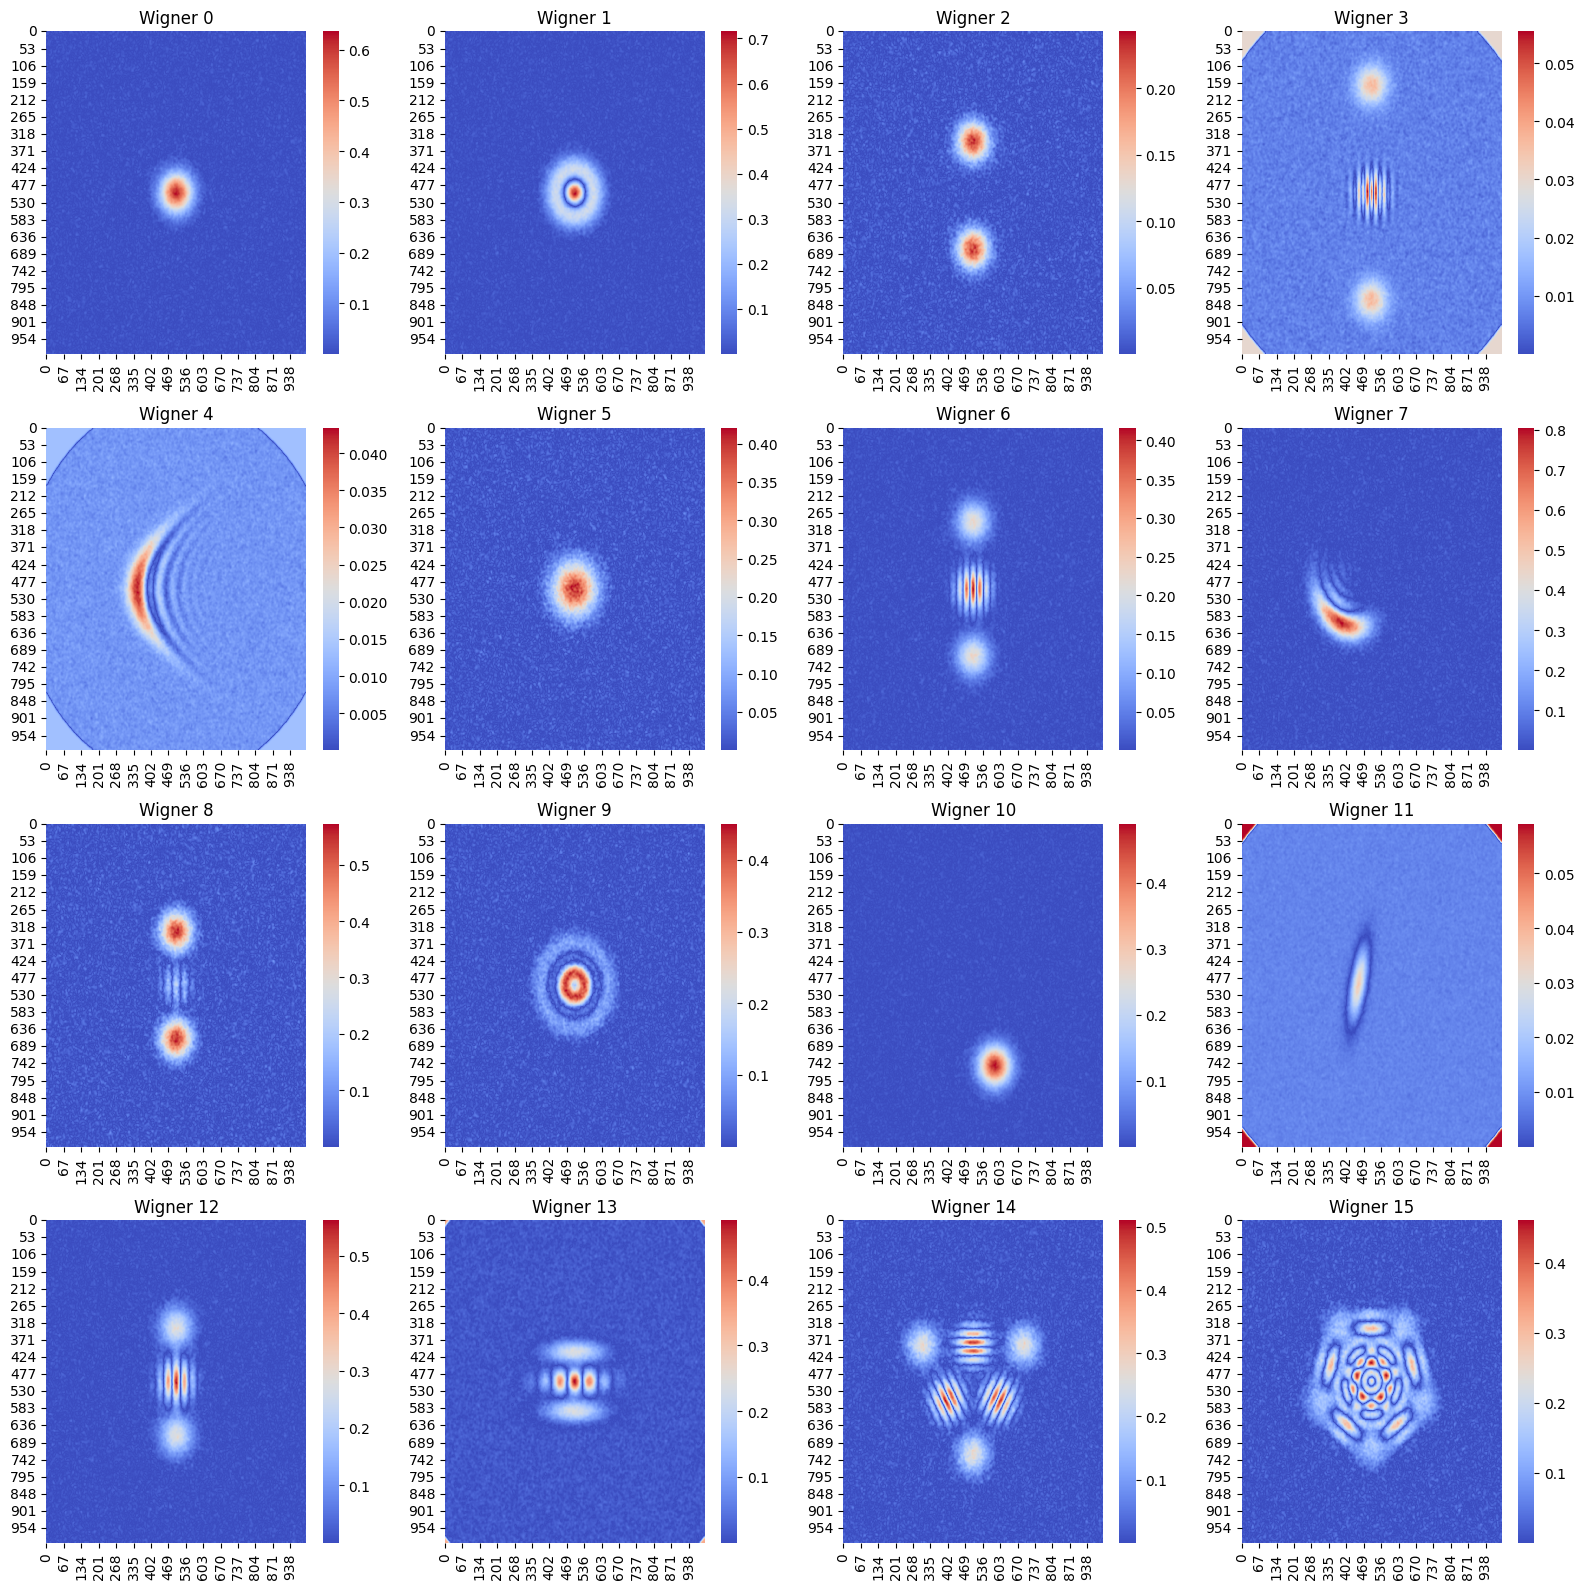

In [ ]:
from scipy.ndimage import gaussian_filter
wigner_files = sorted(glob.glob('/content/drive/MyDrive/QC @ CMU/Spring (2025)/YQuantum/noisy/noisy_wigner_*.pickle'))

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

b_arr = []
a_arr = []

for i, file_path in enumerate(wigner_files):
  if i >= 16:
    break

  data = pickle.load(open(file_path, 'rb'))

  x = np.array(data[0])
  y = np.array(data[1])
  wigner_data = np.array(data[2])

  base_name = os.path.basename(file_path).replace('.pickle', '')
  np.save(f'/content/drive/MyDrive/QC @ CMU/Spring (2025)/YQuantum/noisy/{base_name}_x.npy', x)
  np.save(f'/content/drive/MyDrive/QC @ CMU/Spring (2025)/YQuantum/noisy/{base_name}_y.npy', y)
  np.save(f'/content/drive/MyDrive/QC @ CMU/Spring (2025)/YQuantum/noisy/{base_name}_wigner.npy', wigner_data)

  axes[i].set_title(f'Wigner {i}')
  axes[i].set_xlabel('')
  axes[i].set_ylabel('')
  axes[i].set_xticks([])
  axes[i].set_yticks([])


  # data cleaning
  safe_wigner_data = np.nan_to_num(wigner_data)
  edge_location = len(safe_wigner_data) - 1

  total = 0

  b = (sum(safe_wigner_data[edge_location, :]) + sum(safe_wigner_data[:, edge_location]) + sum(safe_wigner_data[0, :]) + sum(safe_wigner_data[:, 0]))/(4 * edge_location)
  safe_wigner_data = safe_wigner_data - b
  b_arr.append(b)

  a = np.trapz(np.trapezoid(safe_wigner_data, x), y)
  safe_wigner_data = safe_wigner_data/ a
  a_arr.append(a)

  sigma = 3
  safe_wigner_data = gaussian_filter(safe_wigner_data, sigma=sigma)
  sns.heatmap(abs(safe_wigner_data), cmap='coolwarm', cbar=True, ax=axes[i])

plt.tight_layout()
plt.show()

In [ ]:
print(b_arr)
print(a_arr)

[np.float64(1.0411795974374414), np.float64(-0.15504536796566304), np.float64(-0.010017034058909849), np.float64(0.41950412544312776), np.float64(0.2346102436510352), np.float64(0.15725758885806268), np.float64(-0.19663807251178347), np.float64(0.1873826022288791), np.float64(0.8661162460649813), np.float64(0.8282091012289813), np.float64(-0.49378051460013017), np.float64(-0.5358633173031134), np.float64(0.356230058301766), np.float64(-0.33744919933266826), np.float64(0.30815277167701266), np.float64(0.8233824461862609)]
[np.float64(1.6922508600129715), np.float64(0.8093698174913079), np.float64(1.3885006211533606), np.float64(14.084873572522653), np.float64(17.61287498619006), np.float64(0.8764110580652147), np.float64(1.2576075986602415), np.float64(0.821729843216877), np.float64(0.8799623452598944), np.float64(1.2339987152236824), np.float64(0.9088354782890136), np.float64(-9.071699380520435), np.float64(1.3960273445156366), np.float64(-0.974373729197634), np.float64(0.9596708105271

# Denoising

In [ ]:
data = pickle.load(open(wigner_files[14], 'rb'))
x = np.array(data[0])
y = np.array(data[1])
wigner_data = np.array(data[2])
safe_wigner_data = np.nan_to_num(wigner_data)

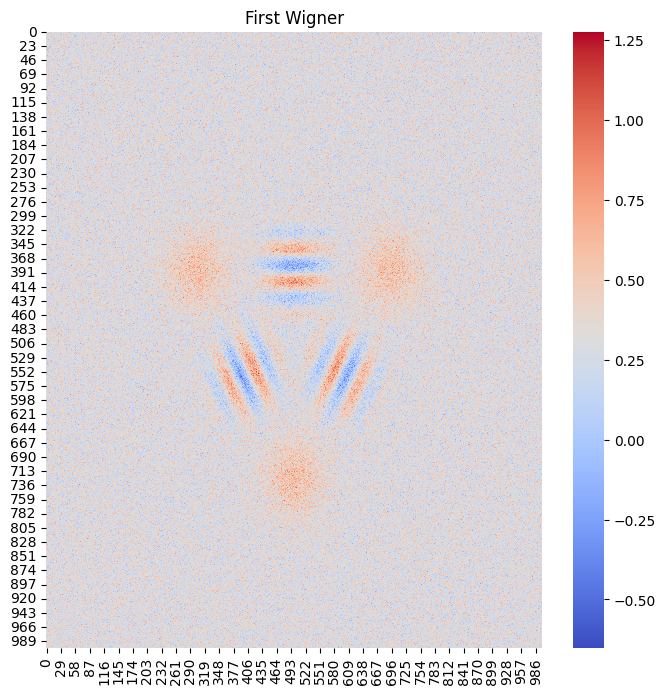

<ipython-input-12-634f2be43b27>:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  wigner_integral = np.trapz(np.trapz(wigner_data, x), y)


Wigner integral: 0.9596708105271021


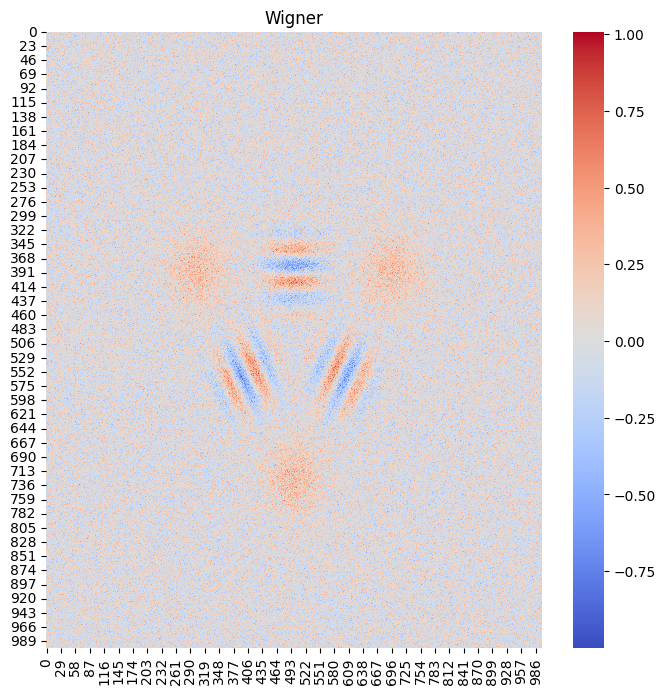

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(wigner_data, cmap='coolwarm', cbar=True, ax=ax)
ax.set_title('First Wigner')
plt.show()

# In most physical states, at the edges of phase space $W(x,p) \rightarrow0$.  This should allow you to estimate the value of $b$.
edge_location = len(wigner_data) -1
b = (sum(wigner_data[edge_location, :]) + sum(wigner_data[:, edge_location]) + sum(wigner_data[0, :]) + sum(wigner_data[:, 0]))/(4 * edge_location)
wigner_data = wigner_data - b

# Normalize the Wigner function
wigner_integral = np.trapz(np.trapz(wigner_data, x), y)
wigner_data = wigner_data/ wigner_integral
print(f'Wigner integral: {wigner_integral}')


fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(wigner_data, cmap='coolwarm', cbar=True, ax=ax)
ax.set_title('Wigner')
plt.show()